## Experiments

Here you can organize all the experiments and exploration as you figure out how to collect and analyze your data and build your NLP tool. The experiments you conduct here will contribute to the report/presentation of your project.

Once you've finalized everything, you should then transfer the parts that are necessary for your demo to the code in the `nlp` folder.

In [16]:
# configure matplotlib to print pretty figures 
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

#other imports
import pandas as pd
import numpy as np
import random
import torch

/var/folders/9q/49vs25x908l6hq8snfm40n600000gn/T/ipykernel_11258/701103452.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'png')


# Data

In [17]:
#pull data from hugging face
from datasets import load_dataset
ethics_data = load_dataset("hendrycks/ethics", "commonsense")

In [18]:
from collections import Counter

#checking balance:
train_count = Counter(ethics_data['train']['label'])
test_count = Counter(ethics_data['test']['label'])
validate_count = Counter(ethics_data['validation']['label'])
print(f"Train has: {train_count[0]} 0 and {train_count[1]} 1, for balance {train_count[0]/train_count[1]:.4f}")
print(f"Test has: {test_count[0]} 0 and {test_count[1]} 1, for balance {test_count[0]/test_count[1]:.4f}")
print(f"Validate has: {validate_count[0]} 0 and {validate_count[1]} 1, for balance {validate_count[0]/validate_count[1]:.4f}")

Train has: 7556 0 and 6354 1, for balance 1.1892
Test has: 1873 0 and 2091 1, for balance 0.8957
Validate has: 2069 0 and 1816 1, for balance 1.1393


# Log Reg

In [19]:
#preprocessing:

#lets start with simple one hot encoding
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)
vectorizer.fit(ethics_data['train']['input'])


CountVectorizer(binary=True)

In [20]:
from sklearn.linear_model import LogisticRegression

X_train = vectorizer.transform(ethics_data['train']['input'])
y_train = ethics_data['train']['label']

X_test = vectorizer.transform(ethics_data['test']['input'])
y_test = ethics_data['test']['label']

X_verify = vectorizer.transform(ethics_data['validation']['input'])
y_verify = ethics_data['validation']['label']

#setting a random seed for replicability
random.seed(561)

clf = LogisticRegression(max_iter=250)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=250)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

print("Log On Validate")
print(classification_report(y_verify, clf.predict(X_verify)))

print("Log On Test")
print(classification_report(y_test, clf.predict(X_test)))
cf_log_reg = confusion_matrix(y_verify, clf.predict(X_verify))

Log On Validate
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      2069
           1       0.77      0.65      0.71      1816

    accuracy                           0.75      3885
   macro avg       0.75      0.74      0.74      3885
weighted avg       0.75      0.75      0.74      3885

Log On Test
              precision    recall  f1-score   support

           0       0.48      0.59      0.53      1873
           1       0.53      0.42      0.47      2091

    accuracy                           0.50      3964
   macro avg       0.50      0.50      0.50      3964
weighted avg       0.51      0.50      0.50      3964



So we did pretty bad huh.

# BERT Classfication 

In [45]:
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch


#good try, you don't get my hugginface token
h_token_w = open("/Users/hlyon/.cache/huggingface/token", 'r').read()
login(h_token_w)


#class labels
id2label = {0: "ACCEPTABLE", 1: "UNETHICAL"}
label2id = {"ACCEPTABLE": 0, "UNETHICAL": 1}

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/hlyon/.cache/huggingface/token
Login successful


In [9]:


#grabbing the model and requisite tokenizer
d_model_name = "distilbert/distilbert-base-uncased"
d_tokenizer = AutoTokenizer.from_pretrained(d_model_name, model_max_length=512)
d_model = AutoModelForSequenceClassification.from_pretrained(d_model_name, num_labels=2, id2label=id2label, label2id=label2id, dropout=.5)

#trying roberta
r_model_name = "roberta-base"
r_tokenizer = AutoTokenizer.from_pretrained(r_model_name, model_max_length=512)
r_model = AutoModelForSequenceClassification.from_pretrained(r_model_name, id2label=id2label, label2id=label2id, hidden_dropout_prob=.2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
#tokenizing data for training

d_tokenized_ethics = ethics_data.map(lambda d : d_tokenizer(d['input'], truncation=True, max_length=512), batched=True)
r_tokenized_ethics = ethics_data.map(lambda d : r_tokenizer(d['input'], return_tensors="pt", padding=True, truncation=True, max_length=512), batched=True)

Map: 100%|██████████| 3964/3964 [00:01<00:00, 1989.10 examples/s]


In [56]:
# set up some components of pytorch training sequence
from transformers import DataCollatorWithPadding
import evaluate


d_data_collator = DataCollatorWithPadding(tokenizer=d_tokenizer)
r_data_collator = DataCollatorWithPadding(tokenizer=r_tokenizer)
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [11]:
#define trainers for finetuning. WARNING: Running both trainers sequentially may lead to memory issues on even decent hardware.

d_training_args = TrainingArguments(

    output_dir="distilbert-ethics-test_dropout",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True

)

d_trainer = Trainer(

    model=d_model,
    args=d_training_args,
    train_dataset=d_tokenized_ethics["train"],
    eval_dataset=d_tokenized_ethics["validation"],
    tokenizer=d_tokenizer,
    data_collator=d_data_collator,
    compute_metrics=compute_metrics

)

#define for roberta
r_training_args = TrainingArguments(

    output_dir="roberta_ethics_test_dropout",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True

)

r_trainer = Trainer(

    model=r_model,
    args=r_training_args,
    train_dataset=r_tokenized_ethics["train"],
    eval_dataset=r_tokenized_ethics["validation"],
    tokenizer=r_tokenizer,
    data_collator=r_data_collator,
    compute_metrics=compute_metrics

)


In [21]:
d_trainer.train()

 19%|█▉        | 500/2610 [09:46<40:38,  1.16s/it]

{'loss': 0.6868, 'grad_norm': 2.2535200119018555, 'learning_rate': 8.084291187739464e-06, 'epoch': 0.57}


                                                     
 33%|███▎      | 870/2610 [40:19<28:28,  1.02it/s]

{'eval_loss': 0.6360511183738708, 'eval_accuracy': 0.6414414414414414, 'eval_runtime': 44.5842, 'eval_samples_per_second': 87.138, 'eval_steps_per_second': 5.45, 'epoch': 1.0}


 38%|███▊      | 1000/2610 [42:33<27:15,  1.02s/it] 

{'loss': 0.6426, 'grad_norm': 6.216912746429443, 'learning_rate': 6.1685823754789275e-06, 'epoch': 1.15}


 57%|█████▋    | 1500/2610 [50:59<18:33,  1.00s/it]

{'loss': 0.6162, 'grad_norm': 5.720035076141357, 'learning_rate': 4.252873563218391e-06, 'epoch': 1.72}


                                                   
 67%|██████▋   | 1740/2610 [55:44<13:41,  1.06it/s]

{'eval_loss': 0.5749624371528625, 'eval_accuracy': 0.7099099099099099, 'eval_runtime': 38.0526, 'eval_samples_per_second': 102.096, 'eval_steps_per_second': 6.386, 'epoch': 2.0}


 77%|███████▋  | 2000/2610 [1:00:17<10:26,  1.03s/it]

{'loss': 0.5922, 'grad_norm': 7.933433532714844, 'learning_rate': 2.3371647509578546e-06, 'epoch': 2.3}


 96%|█████████▌| 2500/2610 [1:09:23<01:58,  1.08s/it]

{'loss': 0.584, 'grad_norm': 6.882735729217529, 'learning_rate': 4.2145593869731807e-07, 'epoch': 2.87}


                                                     
100%|██████████| 2610/2610 [1:12:03<00:00,  1.01it/s]

{'eval_loss': 0.5665436387062073, 'eval_accuracy': 0.7168597168597168, 'eval_runtime': 40.2394, 'eval_samples_per_second': 96.547, 'eval_steps_per_second': 6.039, 'epoch': 3.0}


100%|██████████| 2610/2610 [1:12:05<00:00,  1.66s/it]


{'train_runtime': 4325.577, 'train_samples_per_second': 9.647, 'train_steps_per_second': 0.603, 'train_loss': 0.6226368315831912, 'epoch': 3.0}


TrainOutput(global_step=2610, training_loss=0.6226368315831912, metrics={'train_runtime': 4325.577, 'train_samples_per_second': 9.647, 'train_steps_per_second': 0.603, 'total_flos': 5501317768753752.0, 'train_loss': 0.6226368315831912, 'epoch': 3.0})

In [12]:
r_trainer.train()

 29%|██▊       | 500/1740 [25:43<39:19,  1.90s/it]   

{'loss': 0.6681, 'grad_norm': 24.436416625976562, 'learning_rate': 7.126436781609196e-06, 'epoch': 0.57}


                                                  
 50%|█████     | 870/1740 [38:48<23:51,  1.65s/it]

{'eval_loss': 0.4967503249645233, 'eval_accuracy': 0.7758043758043758, 'eval_runtime': 75.1914, 'eval_samples_per_second': 51.668, 'eval_steps_per_second': 3.232, 'epoch': 1.0}


 57%|█████▋    | 1000/1740 [43:03<23:27,  1.90s/it] 

{'loss': 0.5533, 'grad_norm': 23.782766342163086, 'learning_rate': 4.252873563218391e-06, 'epoch': 1.15}


 86%|████████▌ | 1500/1740 [58:29<07:18,  1.83s/it]

{'loss': 0.5119, 'grad_norm': 27.419784545898438, 'learning_rate': 1.3793103448275862e-06, 'epoch': 1.72}


                                                     
100%|██████████| 1740/1740 [1:06:57<00:00,  1.61s/it]

{'eval_loss': 0.4340294301509857, 'eval_accuracy': 0.8023166023166023, 'eval_runtime': 66.9961, 'eval_samples_per_second': 57.988, 'eval_steps_per_second': 3.627, 'epoch': 2.0}


100%|██████████| 1740/1740 [1:06:59<00:00,  2.31s/it]


{'train_runtime': 4019.4059, 'train_samples_per_second': 6.921, 'train_steps_per_second': 0.433, 'train_loss': 0.5666551436500987, 'epoch': 2.0}


TrainOutput(global_step=1740, training_loss=0.5666551436500987, metrics={'train_runtime': 4019.4059, 'train_samples_per_second': 6.921, 'train_steps_per_second': 0.433, 'total_flos': 7319749560115200.0, 'train_loss': 0.5666551436500987, 'epoch': 2.0})

In [29]:
#now we can check the accuracy
from transformers import pipeline

d_classifier = pipeline("sentiment-analysis", model="distilbert-ethics-test", tokenizer=d_tokenizer)
d_d_classifier = pipeline("sentiment-analysis", model="distilbert-ethics-test_dropout", tokenizer=d_tokenizer)
r_classifier = pipeline("sentiment-analysis", model="roberta_ethics_test", tokenizer=r_tokenizer)
r_d_classifier = pipeline("sentiment-analysis", model="roberta_ethics_test_dropout", tokenizer=r_tokenizer)


So now we have a model that will try to decide if any given sentence is acceptable or unethical, let's do a quick and dirty accuracy test.

In [13]:
#very inefficient transformation
def clean(class_list):
    return [label2id[c['label']] for c in class_list]

d_classification_test = d_classifier(ethics_data['test']['input'], **{'padding':True,'truncation':True,'max_length':512})
d_classification_validation = d_classifier(ethics_data['validation']['input'], **{'padding':True,'truncation':True,'max_length':512})
d_cleaned_test = clean(d_classification_test)
d_cleaned_validation = clean(d_classification_validation)

d_d_classification_test = d_d_classifier(ethics_data['test']['input'], **{'padding':True,'truncation':True,'max_length':512})
d_d_classification_validation = d_d_classifier(ethics_data['validation']['input'], **{'padding':True,'truncation':True,'max_length':512})
d_d_cleaned_test = clean(d_d_classification_test)
d_d_cleaned_validation = clean(d_d_classification_validation)

In [30]:
r_classification_validation = r_classifier(ethics_data['validation']['input'], **{'padding':True,'truncation':True,'max_length':512})
r_cleaned_validation = clean(r_classification_validation)

r_classification_test = r_classifier(ethics_data['test']['input'], **{'padding':True,'truncation':True, 'max_length':512})
r_cleaned_test = clean(r_classification_test)

r_d_classification_validation = r_d_classifier(ethics_data['validation']['input'], **{'padding':True,'truncation':True,'max_length':512})
r_d_cleaned_validation = clean(r_d_classification_validation)

r_d_classification_test = r_d_classifier(ethics_data['test']['input'], **{'padding':True,'truncation':True, 'max_length':512})
r_d_cleaned_test = clean(r_d_classification_test)

In [32]:
print("DistilBert On Test")
print(classification_report(ethics_data['test']['label'], d_cleaned_test))

print("DistilBert w/ High Dropout On Test")
print(classification_report(ethics_data['test']['label'], d_d_cleaned_test))

print("Robert on Validate")
print(classification_report(ethics_data['validation']['label'], r_cleaned_validation))

print("Roberta on Test")
print(classification_report(ethics_data['test']['label'], r_cleaned_test))

print("Roberta w/ High Dropout on Test")
print(classification_report(ethics_data['test']['label'], r_d_cleaned_test))

DistilBert On Test
              precision    recall  f1-score   support

           0       0.43      0.56      0.49      1873
           1       0.46      0.33      0.38      2091

    accuracy                           0.44      3964
   macro avg       0.44      0.45      0.43      3964
weighted avg       0.44      0.44      0.43      3964

DistilBert w/ High Dropout On Test
              precision    recall  f1-score   support

           0       0.43      0.56      0.49      1873
           1       0.46      0.33      0.38      2091

    accuracy                           0.44      3964
   macro avg       0.44      0.45      0.43      3964
weighted avg       0.44      0.44      0.43      3964

Robert on Validate
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2069
           1       0.85      0.82      0.84      1816

    accuracy                           0.85      3885
   macro avg       0.85      0.85      0.85      3885
w

In [33]:
#Lets make some graphs
r_cf_matrix_test = confusion_matrix(ethics_data['test']['label'], r_cleaned_test)
r_cf_matrix_validation = confusion_matrix(ethics_data['validation']['label'], r_cleaned_validation)


In [35]:
import seaborn as sns

#graphing code stolen shamelessly from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

def graph_cf(cf_matrix, title):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in  zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues').set(title=f"{title}\nAccuracy: {(cf_matrix[0][0] + cf_matrix[1][1]) / (cf_matrix[0].sum() + cf_matrix[1].sum()):.4f}")

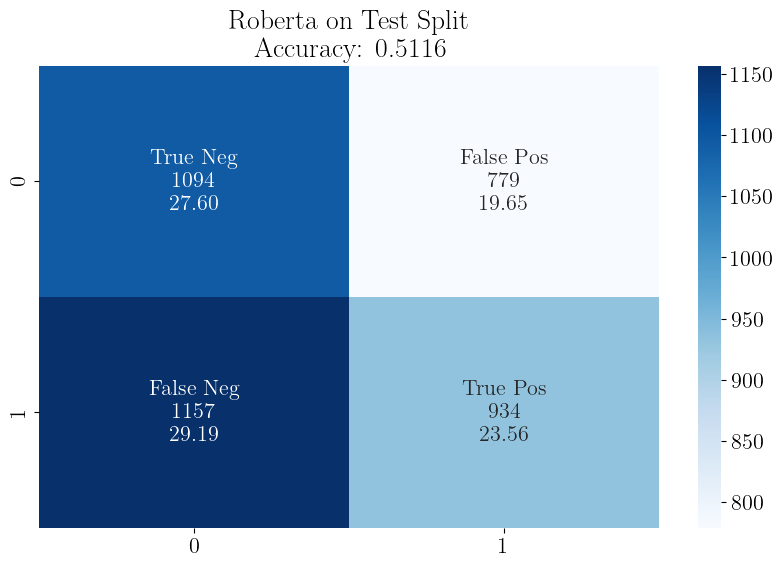

In [36]:
graph_cf(r_cf_matrix_test, "Roberta on Test Split")

## Data Re-Shuffling

Further looking into the existing work on this dataset there is reason to suspect that the 'test' split provided by the dataset consists of exclusively harder ethical questions, skewing our performance. Let's bypass this by shuffling the data and producing a new train, validation, and test split.

In [72]:
from sklearn.model_selection import train_test_split

inputs = ethics_data['train']['input'] + ethics_data['validation']['input'] + ethics_data['test']['input']
labels = ethics_data['train']['label'] + ethics_data['validation']['label'] + ethics_data['test']['label']

#first split, taking 25% of data as test set
TV_in, test_in, TV_lab, test_lab = train_test_split(inputs, labels, stratify=labels, test_size=.25, random_state=561, shuffle=True)

#second split, splitting non-test data into 70% train and 30% validate
train_in, validate_in, train_lab, validate_lab = train_test_split(TV_in, TV_lab, stratify=TV_lab, test_size=.3, random_state=561, shuffle=True)

#throw these into a dictionary so we can re-use code.
ethics_shuffled = {'train':{'input':train_in, 'label':train_lab}, 'validation':{'input':validate_in, 'label':validate_lab}, 'test':{'input':test_in, 'label':test_lab}}

We're just going to train roberta using basic settings on this.

In [73]:
shuffled_model_name = "roberta-base"
shuffled_tokenizer = AutoTokenizer.from_pretrained(r_model_name, model_max_length=512)
shuffled_model = AutoModelForSequenceClassification.from_pretrained(r_model_name, id2label=id2label, label2id=label2id)
shuffled_data_collator = DataCollatorWithPadding(tokenizer=r_tokenizer)
shuffled_tokenized_ethics = ethics_data.map(lambda d : shuffled_tokenizer(d['input'], return_tensors="pt", padding=True, truncation=True, max_length=512), batched=True)

shuffled_training_args = TrainingArguments(

    output_dir="roberta_ethics_test_shuffled",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True

)

shuffled_trainer = Trainer(

    model=shuffled_model,
    args=shuffled_training_args,
    train_dataset=shuffled_tokenized_ethics["train"],
    eval_dataset=shuffled_tokenized_ethics["validation"],
    tokenizer=shuffled_tokenizer,
    data_collator=shuffled_data_collator,
    compute_metrics=compute_metrics

)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
shuffled_trainer.train()

 29%|██▊       | 500/1740 [15:20<37:37,  1.82s/it]

{'loss': 0.6182, 'grad_norm': 45.36472702026367, 'learning_rate': 7.126436781609196e-06, 'epoch': 0.57}


 50%|█████     | 870/1740 [46:09<27:48,  1.92s/it]

{'eval_loss': 0.42781129479408264, 'eval_accuracy': 0.8074646074646075, 'eval_runtime': 87.6315, 'eval_samples_per_second': 44.333, 'eval_steps_per_second': 2.773, 'epoch': 1.0}


 57%|█████▋    | 1000/1740 [51:16<28:50,  2.34s/it] 

{'loss': 0.5011, 'grad_norm': 20.41248321533203, 'learning_rate': 4.252873563218391e-06, 'epoch': 1.15}


 86%|████████▌ | 1500/1740 [3:15:42<08:44,  2.19s/it]     

{'loss': 0.4461, 'grad_norm': 24.79361915588379, 'learning_rate': 1.3793103448275862e-06, 'epoch': 1.72}


100%|██████████| 1740/1740 [3:49:12<00:00,  1.59s/it]

{'eval_loss': 0.3940369486808777, 'eval_accuracy': 0.8205920205920206, 'eval_runtime': 74.126, 'eval_samples_per_second': 52.411, 'eval_steps_per_second': 3.278, 'epoch': 2.0}


100%|██████████| 1740/1740 [3:49:15<00:00,  7.91s/it]


{'train_runtime': 13755.0305, 'train_samples_per_second': 2.023, 'train_steps_per_second': 0.126, 'train_loss': 0.5097780775749821, 'epoch': 2.0}


TrainOutput(global_step=1740, training_loss=0.5097780775749821, metrics={'train_runtime': 13755.0305, 'train_samples_per_second': 2.023, 'train_steps_per_second': 0.126, 'total_flos': 7319749560115200.0, 'train_loss': 0.5097780775749821, 'epoch': 2.0})

In [82]:
shuffled_classifier = pipeline("sentiment-analysis", model="roberta_ethics_test_shuffled", tokenizer=shuffled_tokenizer)


#transform shuffled splits
sh_validation = shuffled_classifier(ethics_shuffled['validation']['input'], **{'padding':True,'truncation':True,'max_length':512})
sh_validation_clean = clean(sh_validation)

sh_test = shuffled_classifier(ethics_shuffled['test']['input'], **{'padding':True,'truncation':True, 'max_length':512})
sh_test_clean = clean(sh_test)

#and the original splits
og_sh_validation = shuffled_classifier(ethics_data['validation']['input'], **{'padding':True,'truncation':True,'max_length':512})
og_sh_validation_clean = clean(sh_validation)

og_sh_test = shuffled_classifier(ethics_data['test']['input'], **{'padding':True,'truncation':True, 'max_length':512})
og_sh_test_clean = clean(og_sh_test)

In [83]:
print(classification_report(validate_lab, sh_validation_clean))
print(classification_report(test_lab, sh_test_clean))
print(len(ethics_data['test']['input']), len(ethics_data['test']['label']))
print(classification_report(ethics_data['test']['label'], og_sh_test_clean))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2587
           1       0.76      0.76      0.76      2309

    accuracy                           0.78      4896
   macro avg       0.77      0.77      0.77      4896
weighted avg       0.78      0.78      0.78      4896

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      2875
           1       0.77      0.75      0.76      2565

    accuracy                           0.78      5440
   macro avg       0.77      0.77      0.77      5440
weighted avg       0.77      0.78      0.77      5440

3964 3964
              precision    recall  f1-score   support

           0       0.47      0.55      0.51      1873
           1       0.53      0.45      0.48      2091

    accuracy                           0.50      3964
   macro avg       0.50      0.50      0.50      3964
weighted avg       0.50      0.50      0.49      3964



## LLAMA Classification

Unfortunately I was unable to get Llama classification working even at the 7b model - my hardware is at the very edge of being able to load and tune the model, despite optimizations like loading half precision weights and min-maxing steps sizes, and this realization came too late to effectively look into alternate resources or platforms. Below is the code I *would* have used if I had more memory on my machine. 

In [4]:
from transformers import LlamaForSequenceClassification, LlamaTokenizer
import sentencepiece

import urllib3, socket
from urllib3.connection import HTTPConnection

HTTPConnection.default_socket_options = ( 
    HTTPConnection.default_socket_options + [
    (socket.SOL_SOCKET, socket.SO_SNDBUF, 2000000), 
    (socket.SOL_SOCKET, socket.SO_RCVBUF, 2000000)
    ])

l_model_name = "meta-llama/Llama-2-7b-hf"
l_model = LlamaForSequenceClassification.from_pretrained(l_model_name, resume_download=True, torch_dtype=torch.float16)
l_tokenizer = LlamaTokenizer.from_pretrained(l_model_name, fast=True)

l_tokenizer.add_special_tokens({"pad_token":"<pad>"})
l_tokenizer.padding_side = 'left'


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
#data prep
l_tokenized_ethics = ethics_data.map(lambda d : l_tokenizer(d['input'], padding=True, return_tensors="pt"), batched=True)

In [7]:
l_training_arguments = TrainingArguments(
    output_dir="llama-7b-ethics-test",
    learning_rate=1e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    #num_train_epochs=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    #load_best_model_at_end=True,
    push_to_hub=True,
    optim="paged_adamw_32bit",
    save_steps=2,
    max_grad_norm=0.3,
    max_steps=10,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    do_eval=True
)

l_trainer = Trainer(
    model=l_model,
    train_dataset=l_tokenized_ethics['train'],
    eval_dataset=l_tokenized_ethics['validation'],
    tokenizer=l_tokenizer,
    args=l_training_arguments,
)

max_steps is given, it will override any value given in num_train_epochs


In [8]:
l_trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 35.18 GB, other allocations: 1.05 GB, max allowed: 36.27 GB). Tried to allocate 51.22 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).